In [1]:
import pandas as pd
from datetime import datetime
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import copy

from distfit import distfit

In [2]:
with open("./graph_networkx_CNHK_USA_FINAL_route.pkl", 'rb') as f:
    G_loaded = pickle.load(f)
    G = copy.deepcopy(G_loaded)

### Plot based on longitude, latitude

In [3]:
f = open("data_av/msc_route_country_port_codes.json")
dict_ports = json.load(f)

In [4]:
#Plot nodes based on location
for node, attributes in G.nodes(data=True):
    try:
        attributes["latitude"] = dict_ports[node]["LocationLatitude"]
        attributes["longitude"] = dict_ports[node]["LocationLongitude"]
    except KeyError:
        raise Warning("Port {0} cannot be found".format(node))
        
position_ports = {k: (attr["longitude"], attr["latitude"]) for k, attr in G.nodes(data=True)}

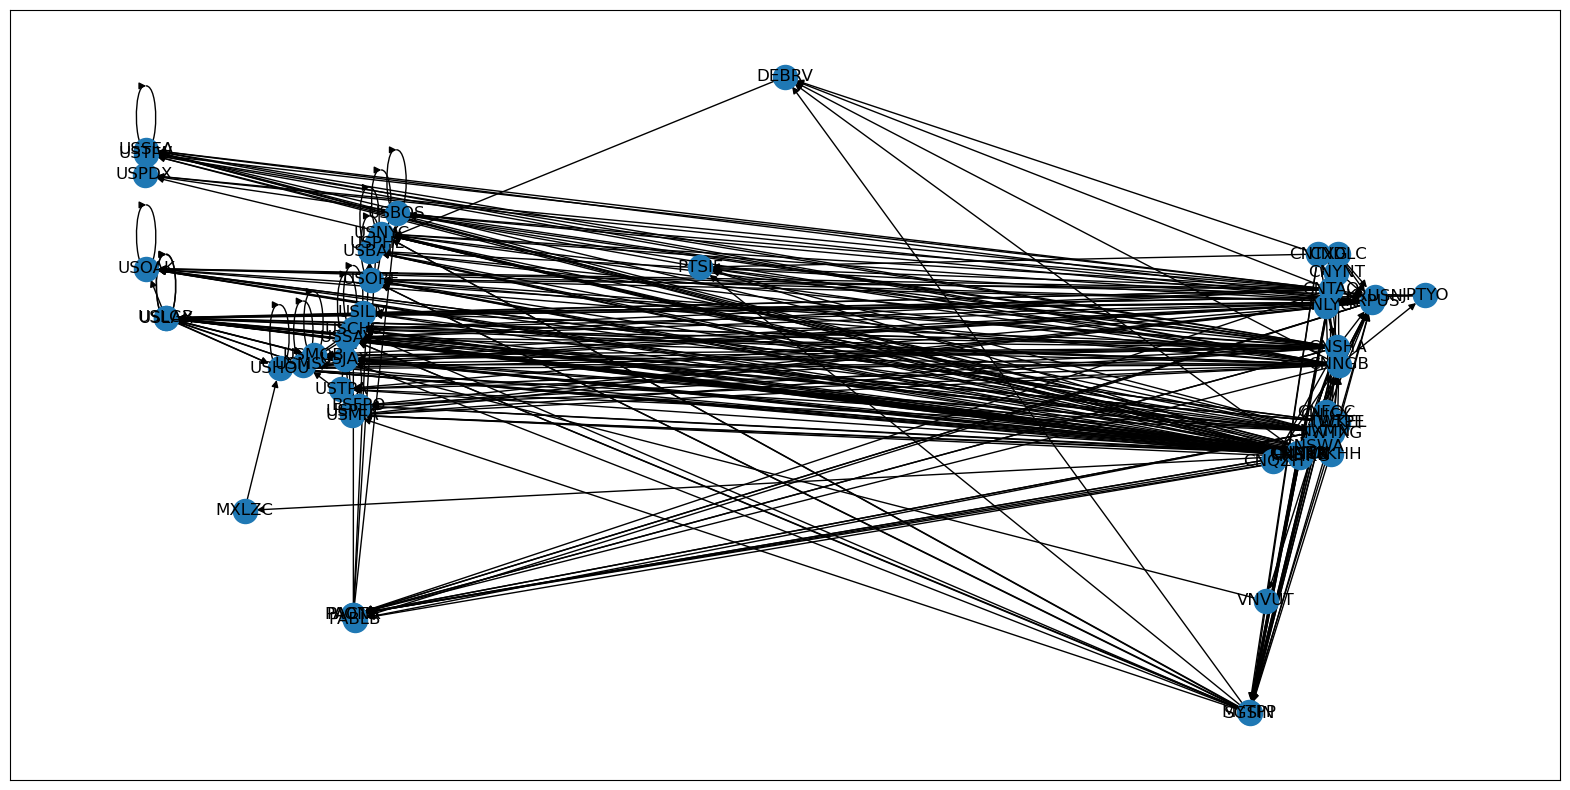

In [5]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=position_ports)

# Create histogram of the edges

In [9]:
#Add frequency of the duplicates
for edge in G.edges(data=True):
    etd = edge[2]["etd_origin"]
    eta = edge[2]["eta_destination"]
    time = edge[2]["time_minutes"]
    
    combine = []
    for (o, d, t) in zip(etd, eta, time):
        combine.append((o, d, t))
        
    freq = {}
    for i in combine:
        freq[i] = combine.count(i)
        
    median_time_minutes = np.median([k[2] for k,v in freq.items()])

    G.edges[edge[0], edge[1]]["frequency"] = freq
    G.edges[edge[0], edge[1]]["median_time_minutes"] = median_time_minutes
    
    #also add modality
    G.edges[edge[0], edge[1]]["modality"] = "sea"
    if len(freq) <=5:
        print(f"Connection {edge[0]} to {edge[1]} has {len(freq)} datapoints")

Connection CNXMN to PTSIE has 5 datapoints
Connection KRPUS to USPEF has 2 datapoints
Connection CNTAO to PTSIE has 2 datapoints
Connection CNNSA to CNSHA has 1 datapoints
Connection CNSHK to USLGB has 1 datapoints
Connection CNTXG to PTSIE has 1 datapoints


In [16]:
G.edges["CNNSA", "CNSHA"]

{'time_minutes': [4320.0, 4320.0],
 'eta_destination': [datetime.datetime(2023, 12, 1, 0, 0),
  datetime.datetime(2023, 12, 1, 0, 0)],
 'etd_origin': [datetime.datetime(2023, 11, 28, 0, 0),
  datetime.datetime(2023, 11, 28, 0, 0)],
 'frequency': {(datetime.datetime(2023, 11, 28, 0, 0),
   datetime.datetime(2023, 12, 1, 0, 0),
   4320.0): 2},
 'median_time_minutes': 4320.0,
 'modality': 'sea'}

In [7]:
# for edge in G.edges(data=True):
#     plt.figure(figsize=(4,4))
#     plt.title(edge[0] + " to " + edge[1])
#     plt.ylabel("Frequency")
#     plt.xlabel("Days")
# #     plt.hist([k/60/24 for k in edge[2]["time_minutes"]])
#     plt.hist([k[2]/60/24 for k, v in edge[2]["frequency"].items()])

# Fit distributions on histograms

We will use *distfit*. Advantages are that it calculates the KS correctly and is faster. Disadvantages are that it only gives plot results of the best fitted distribution, and only one statistic for determining the fit is calculated per comparison (we can do multiple).

In [18]:
dist_to_fit = ["expon", "beta", "uniform", "triang"]

In [19]:
for edge in G.edges(data=True):
    
    data = np.array([k[2] for k, v in edge[2]["frequency"].items()]) #minutes (not days)
    unique_value, unique_count = np.unique(data, return_counts=True)
    n_obs = len(data)
    
    if len(unique_value) == 1:
        G.edges[edge[0], edge[1]]["distribution"] = {"deterministic": {"params": unique_value}}
    
    elif len(unique_value) > 1 and n_obs < 30:
        normalized_unique_count = [float(i)/sum(unique_count) for i in unique_count]
        G.edges[edge[0], edge[1]]["distribution"] = {"discrete": {"model": np.random.choice,
                                                                "params": (unique_value, normalized_unique_count)}}
        
    else:
        dfit_rss = distfit(distr=dist_to_fit, stats="RSS")
        dfit_ks = distfit(distr=dist_to_fit, stats="ks")

        results_rss = dfit_rss.fit_transform(data)
        results_ks = dfit_ks.fit_transform(data)

        G.edges[edge[0], edge[1]]["distribution_full"] = {"RSS": results_rss, "KS": results_ks}
        G.edges[edge[0], edge[1]]["distribution"] = {"dist": {"model": results_rss["model"]["model"]}}
    

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.53862e-07] [loc=12540.000 scale=9151.765]
[distfit] >INFO> [beta   ] [0.14 sec] [RSS: 8.59713e-08] [loc=-60962253831.524 scale=60962281331.331]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.18549e-07] [loc=12540.000 scale=13740.000]
[distfit] >INFO> [triang ] [0.46 sec] [RSS: 9.13643e-08] [loc=11924.763 scale=15560.973]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 1.50257] [loc=12540.000 scale=9151.765]
[distfit] >INFO> [beta   ] [0.15 sec] [ks: 0.270756] [loc=-60962253831.524 scale=60962281331.331]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 2.10463] [loc=12540.000 scale=13740.000]
[distfit] >INFO> [triang ] [0.46 sec] [ks: 1.00197] [loc=11924.763 scale=15560.973]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [exp

[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.8722e-08] [loc=21780.000 scale=11765.607]
[distfit] >INFO> [beta   ] [0.18 sec] [RSS: 5.07828e-09] [loc=-426823.278 scale=509942.525]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.92083e-08] [loc=21780.000 scale=21955.000]
[distfit] >INFO> [triang ] [0.23 sec] [RSS: 7.63847e-09] [loc=21093.958 scale=23303.266]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.319528] [loc=21780.000 scale=11765.607]
[distfit] >INFO> [beta   ] [0.19 sec] [ks: 0.00126267] [loc=-426823.278 scale=509942.525]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 1.68321] [loc=21780.000 scale=21955.000]
[distfit] >INFO> [triang ] [0.23 sec] [ks: 0.319528] [loc=21093.958 scale=23303.266]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[dis

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.16082e-07] [loc=15840.000 scale=6830.395]
[distfit] >INFO> [beta   ] [0.26 sec] [RSS: 5.40808e-08] [loc=5537.380 scale=125022.572]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 8.83901e-08] [loc=15840.000 scale=11700.000]
[distfit] >INFO> [triang ] [0.25 sec] [RSS: 7.33617e-08] [loc=15425.634 scale=12364.745]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 1.06036] [loc=15840.000 scale=6830.395]
[distfit] >INFO> [beta   ] [0.19 sec] [ks: 0.180364] [loc=5537.380 scale=125022.572]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 1.06036] [loc=15840.000 scale=11700.000]
[distfit] >INFO> [triang ] [0.25 sec] [ks: 0.548716] [loc=15425.634 scale=12364.745]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 5.

[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.78423e-07] [loc=53640.000 scale=4153.205]
[distfit] >INFO> [beta   ] [0.18 sec] [RSS: 6.39322e-08] [loc=-1218661.081 scale=1353654.888]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 2.17047e-07] [loc=53640.000 scale=8620.000]
[distfit] >INFO> [triang ] [0.36 sec] [RSS: 1.13993e-07] [loc=53337.162 scale=9215.847]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 1.12691] [loc=53640.000 scale=4153.205]
[distfit] >INFO> [beta   ] [0.19 sec] [ks: 0.07957] [loc=-1218661.081 scale=1353654.888]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 2.3599] [loc=53640.000 scale=8620.000]
[distfit] >INFO> [triang ] [0.35 sec] [ks: 0.674739] [loc=53337.162 scale=9215.847]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.99475e-07] [loc=1440.000 scale=4032.000]
[di

[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 5.10241e-08] [loc=13320.000 scale=9161.878]
[distfit] >INFO> [beta   ] [0.11 sec] [RSS: 1.55402e-08] [loc=-418559331.445 scale=418630370.546]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 3.06505e-08] [loc=13320.000 scale=14248.000]
[distfit] >INFO> [triang ] [0.38 sec] [RSS: 1.687e-08] [loc=13022.364 scale=14972.512]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.180364] [loc=13320.000 scale=9161.878]
[distfit] >INFO> [beta   ] [0.20 sec] [ks: 0.00872572] [loc=-418559331.445 scale=418630370.546]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 0.548716] [loc=13320.000 scale=14248.000]
[distfit] >INFO> [triang ] [0.48 sec] [ks: 0.180364] [loc=13022.364 scale=14972.512]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 7.38679e-08] [loc=16440.000 sc

[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.4406e-08] [loc=4320.000 scale=6557.143]
[distfit] >INFO> [beta   ] [0.09 sec] [RSS: 8.51093e-09] [loc=2461.636 scale=2327870734.586]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.92478e-08] [loc=4320.000 scale=20160.000]
[distfit] >INFO> [triang ] [0.25 sec] [RSS: 9.79107e-09] [loc=2800.414 scale=22398.670]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.07957] [loc=4320.000 scale=6557.143]
[distfit] >INFO> [beta   ] [0.10 sec] [ks: 0.00126267] [loc=2461.636 scale=2327870734.586]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 1.12691] [loc=4320.000 scale=20160.000]
[distfit] >INFO> [triang ] [0.29 sec] [ks: 0.319528] [loc=2800.414 scale=22398.670]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 7.60835e-08] [loc=60.000 scale=5012.343]
[distf

[distfit] >INFO> [beta   ] [0.14 sec] [RSS: 0.000380191] [loc=-10419.214 scale=1135937.176]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 0.000383526] [loc=41760.000 scale=16464.000]
[distfit] >INFO> [triang ] [0.33 sec] [RSS: 0.000381522] [loc=39977.486 scale=18428.337]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: inf] [loc=41760.000 scale=4976.000]
[distfit] >INFO> [beta   ] [0.11 sec] [ks: inf] [loc=-10419.214 scale=1135937.176]
[distfit] >INFO> [uniform] [0.00 sec] [ks: inf] [loc=41760.000 scale=16464.000]
[distfit] >INFO> [triang ] [0.33 sec] [ks: inf] [loc=39977.486 scale=18428.337]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 5.32923e-08] [loc=24420.000 scale=787.983]
[distfit] >INFO> [beta   ] [0.22 sec] [RSS: 6.22637e-08] [loc=24420.000 scale=34812.262]
[distfit] >INFO> [

[distfit] >INFO> [uniform] [0.00 sec] [RSS: 2.76155e-07] [loc=1440.000 scale=51900.000]
[distfit] >INFO> [triang ] [0.25 sec] [RSS: 2.54971e-07] [loc=654.487 scale=53377.138]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 10.6551] [loc=1440.000 scale=46864.957]
[distfit] >INFO> [beta   ] [0.10 sec] [ks: 10.6551] [loc=-707763254159.679 scale=707763307717.190]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 16.4344] [loc=1440.000 scale=51900.000]
[distfit] >INFO> [triang ] [0.29 sec] [ks: 10.6551] [loc=654.487 scale=53377.138]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 6.69013e-08] [loc=9060.000 scale=30178.604]
[distfit] >INFO> [beta   ] [0.20 sec] [RSS: 3.34646e-08] [loc=-249398.447 scale=495972.160]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 6.14021e-08] [loc=9060.000 scale=49499.0

[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.1987e-08] [loc=12240.000 scale=50820.000]
[distfit] >INFO> [triang ] [0.26 sec] [RSS: 6.91771e-09] [loc=11322.741 scale=53011.487]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 1.95081] [loc=12240.000 scale=31939.663]
[distfit] >INFO> [beta   ] [0.19 sec] [ks: 0.370291] [loc=-363752.412 scale=527939.620]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 3.92208] [loc=12240.000 scale=50820.000]
[distfit] >INFO> [triang ] [0.27 sec] [ks: 1.03] [loc=11322.741 scale=53011.487]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.51057e-08] [loc=29340.000 scale=17006.839]
[distfit] >INFO> [beta   ] [0.19 sec] [RSS: 6.86129e-09] [loc=7676.956 scale=3542874496.267]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.98433e-08] [loc=29340.000 scale=34050.000]
[

[distfit] >INFO> [uniform] [0.00 sec] [RSS: 2.92455e-08] [loc=15180.000 scale=14220.000]
[distfit] >INFO> [triang ] [0.40 sec] [RSS: 3.89277e-08] [loc=11638.129 scale=17770.291]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.2402] [loc=15180.000 scale=6541.818]
[distfit] >INFO> [beta   ] [0.15 sec] [ks: 0.2402] [loc=15179.961 scale=14220.039]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 0.673416] [loc=15180.000 scale=14220.000]
[distfit] >INFO> [triang ] [0.41 sec] [ks: 0.2402] [loc=11638.129 scale=17770.291]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 5.6058e-08] [loc=45285.000 scale=9598.868]
[distfit] >INFO> [beta   ] [0.22 sec] [RSS: 4.35078e-08] [loc=42826.360 scale=16694.640]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 3.91326e-08] [loc=45285.000 scale=14236.000]
[distfit] 

[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 1.27548] [loc=2880.000 scale=1069.714]
[distfit] >INFO> [beta   ] [0.11 sec] [ks: 1.27548] [loc=1822.917 scale=3937.083]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 1.27548] [loc=2880.000 scale=2880.000]
[distfit] >INFO> [triang ] [0.30 sec] [ks: 1.27548] [loc=1068.985 scale=4691.641]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.78146e-06] [loc=2160.000 scale=1794.495]
[distfit] >INFO> [beta   ] [0.13 sec] [RSS: 1.75184e-06] [loc=895.842 scale=4864.158]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.85206e-06] [loc=2160.000 scale=3600.000]
[distfit] >INFO> [triang ] [0.47 sec] [RSS: 1.90431e-06] [loc=370.561 scale=5389.439]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[dist

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 2.82479] [loc=2760.000 scale=48788.977]
[distfit] >INFO> [beta   ] [0.13 sec] [ks: 1.50257] [loc=-494188971937.220 scale=494189038299.987]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 2.82479] [loc=2760.000 scale=62040.000]
[distfit] >INFO> [triang ] [0.37 sec] [ks: 2.10463] [loc=957.069 scale=65472.926]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.09212e-07] [loc=17256.000 scale=4759.639]
[distfit] >INFO> [beta   ] [0.24 sec] [RSS: 7.89981e-08] [loc=17131.285 scale=169485212672675136.000]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.74947e-07] [loc=17256.000 scale=47609.000]
[distfit] >INFO> [triang ] [0.26 sec] [RSS: 1.55422e-07] [loc=16178.145 scale=50079.565]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon

[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.0165072] [loc=1440.000 scale=4320.000]
[distfit] >INFO> [beta   ] [0.13 sec] [ks: 0.0165072] [loc=583.021 scale=9496.979]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 1.27548] [loc=1440.000 scale=8640.000]
[distfit] >INFO> [triang ] [0.44 sec] [ks: 0.0165072] [loc=-1673.177 scale=11882.184]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 9.19658e-08] [loc=2515.000 scale=4633.450]
[distfit] >INFO> [beta   ] [0.18 sec] [RSS: 2.5248e-08] [loc=2087.037 scale=706995927349598.250]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.03705e-07] [loc=2515.000 scale=19190.000]
[distfit] >INFO> [triang ] [0.46 sec] [RSS: 6.21722e-08] [loc=2264.369 scale=19680.818]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.413923] [loc=2515.000 scale=4633.450]
[distfit

[distfit] >INFO> [beta   ] [0.14 sec] [ks: 0.0311735] [loc=-0.000 scale=4558.102]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 0.324198] [loc=0.000 scale=4068.000]
[distfit] >INFO> [triang ] [0.20 sec] [ks: 0.324198] [loc=-1032.357 scale=5264.046]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 8.38441e-07] [loc=1440.000 scale=3042.740]
[distfit] >INFO> [beta   ] [0.13 sec] [RSS: 5.1819e-07] [loc=601.290 scale=5878.710]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 7.59579e-07] [loc=1440.000 scale=5040.000]
[distfit] >INFO> [triang ] [0.18 sec] [RSS: 7.34248e-07] [loc=-1865.299 scale=8345.322]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 1.47409] [loc=1440.000 scale=3042.740]
[distfit] >INFO> [beta   ] [0.12 sec] [ks: 1.47409] [loc=601.290 scale=5878.710]
[distfit] >INFO> [uniform] [0.

[distfit] >INFO> [triang ] [0.41 sec] [ks: 1.72937] [loc=1089.731 scale=350.269]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.25494e-08] [loc=24480.000 scale=7530.909]
[distfit] >INFO> [beta   ] [0.19 sec] [RSS: 2.36916e-08] [loc=24480.000 scale=35434.795]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 2.13101e-08] [loc=24480.000 scale=19680.000]
[distfit] >INFO> [triang ] [0.34 sec] [RSS: 2.06613e-08] [loc=19433.049 scale=26849.268]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.0165072] [loc=24480.000 scale=7530.909]
[distfit] >INFO> [beta   ] [0.19 sec] [ks: 0.0165072] [loc=24480.000 scale=35434.795]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 0.673416] [loc=24480.000 scale=19680.000]
[distfit] >INFO> [triang ] [0.31 sec] [ks: 0.2402] [loc=19433.049 scale=26849.268]
[distfit] >

[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 5.32943e-09] [loc=46080.000 scale=6276.000]
[distfit] >INFO> [beta   ] [0.13 sec] [RSS: 1.22248e-08] [loc=46080.000 scale=22760.134]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.56537e-08] [loc=46080.000 scale=20220.000]
[distfit] >INFO> [triang ] [0.16 sec] [RSS: 2.05167e-08] [loc=34042.753 scale=32257.247]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 9.64327e-17] [loc=46080.000 scale=6276.000]
[distfit] >INFO> [beta   ] [0.14 sec] [ks: 0.324198] [loc=46080.000 scale=22760.134]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 0.845098] [loc=46080.000 scale=20220.000]
[distfit] >INFO> [triang ] [0.18 sec] [ks: 0.0311735] [loc=34042.753 scale=32257.247]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit

In [33]:
results_rss["model"]["model"].rvs()

173.12466791508348

In [20]:
for edge in G.edges(data=True):
    print(edge[0], edge[1])
    try:
        print("RSS:", edge[2]["distribution_full"]["RSS"]["model"]["name"], edge[2]["distribution_full"]["RSS"]["model"]["score"])
        print("KS:", edge[2]["distribution_full"]["KS"]["model"]["name"], edge[2]["distribution_full"]["KS"]["model"]["score"])
    except KeyError:
        try:
            print("Deterministic with parameter", edge[2]["distribution"]["deterministic"]["params"][0], "minutes")
        except KeyError:
            print("Discrete with parameters", edge[2]["distribution"]["discrete"]["params"])

CNSHA USLAX
RSS: beta 8.597129992189308e-08
KS: beta 0.27075599969999037
CNSHA USJAX
RSS: beta 4.157236073373368e-06
KS: expon 23.032106464613666
CNSHA USORF
RSS: beta 4.9464526105874044e-08
KS: beta 1.057089070102226
CNSHA USSAV
RSS: beta 2.1110455934331552e-08
KS: beta 0.10732235278230386
CNSHA USILM
Discrete with parameters (array([49002., 49500., 50523., 51498., 51570., 52320., 52440., 52500.,
       53484., 53680., 55002., 56297., 57190., 64931.]), [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.14285714285714285, 0.42857142857142855, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571])
CNSHA SGSIN
RSS: triang 5.816879123258423e-08
KS: expon 1.6957893621328584e-05
CNSHA USTPA
Discrete with parameters (array([40320., 53280., 54720., 57600., 60480., 61920.]), [0.06666666666666667, 0.13333333333333333, 0.6, 0.06666666666666667, 0.0

## Also for processing times at the transit ports

In [21]:
# Make a list of all processing times -- there are no double routes so we do not have to find the unique once
for node, attr in G.nodes(data=True):
    processing_times = []
    
    for k, v in attr.items():
        try:
            if "ProcessingTimeMinutes" in v:
                processing_times.append(v["ProcessingTimeMinutes"])
            else:
                continue
        except TypeError:
            continue

    if len(processing_times) == 0:
        continue
    else:
        G.nodes[node]["all_processing_times_minutes"] = processing_times

In [22]:
dist_to_fit = ["expon", "beta", "uniform", "triang"]

In [23]:
for node, attr in G.nodes(data=True):
    
    if "all_processing_times_minutes" in attr:
    
        data = np.array(attr["all_processing_times_minutes"]) #minutes (not days)
        unique_value, unique_count = np.unique(data, return_counts=True)
        n_obs = len(data)

        if len(unique_value) == 1:
            if unique_value == 0:
                continue
            else:
                G.nodes[node]["processing_distribution"] = {"deterministic": {"params": unique_value}}

        elif len(unique_value) > 1 and n_obs < 30:
            normalized_unique_count = [float(i)/sum(unique_count) for i in unique_count]
            G.nodes[node]["processing_distribution"] = {"discrete": {"model": np.random.choice,
                                                                    "params": (unique_value, normalized_unique_count)}}

        else:
            dfit_rss = distfit(distr=dist_to_fit, stats="RSS")
            dfit_ks = distfit(distr=dist_to_fit, stats="ks")

            results_rss = dfit_rss.fit_transform(data)
            results_ks = dfit_ks.fit_transform(data)

            G.nodes[node]["processing_distribution_full"] = {"RSS": results_rss, "KS": results_ks}
            G.nodes[node]["processing_distribution"] = {"dist": {"model": results_rss["model"]["model"]}}
    else:
        continue

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.22093e-07] [loc=0.000 scale=2872.648]
[distfit] >INFO> [beta   ] [0.30 sec] [RSS: 1.20349e-07] [loc=-0.000 scale=30527.973]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 4.81822e-07] [loc=0.000 scale=28140.000]
[distfit] >INFO> [triang ] [0.45 sec] [RSS: 4.16718e-07] [loc=-172.956 scale=28335.452]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 2.73628] [loc=0.000 scale=2872.648]
[distfit] >INFO> [beta   ] [0.31 sec] [ks: 2.73628] [loc=-0.000 scale=30527.973]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 13.2846] [loc=0.000 scale=28140.000]
[distfit] >INFO> [triang ] [0.52 sec] [ks: 3.52161] [loc=-172.956 scale=28335.452]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.21928e-06] [loc=0.000 scal

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 3.18381] [loc=0.000 scale=1286.985]
[distfit] >INFO> [beta   ] [0.18 sec] [ks: 3.18381] [loc=-490.193 scale=2770.193]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 3.18381] [loc=0.000 scale=2280.000]
[distfit] >INFO> [triang ] [0.22 sec] [ks: 3.18381] [loc=-1803.527 scale=4083.527]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.15434e-05] [loc=0.000 scale=344.498]
[distfit] >INFO> [beta   ] [0.16 sec] [RSS: 2.48436e-05] [loc=-0.000 scale=1440.000]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 2.05034e-05] [loc=0.000 scale=1440.000]
[distfit] >INFO> [triang ] [0.46 sec] [RSS: 1.84957e-05] [loc=-0.013 scale=1785.015]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 2.20109] [loc=0.000 scale=344.498]


[distfit] >INFO> [triang ] [0.50 sec] [ks: 0.180364] [loc=2610.424 scale=12023.676]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 8.01316e-07] [loc=1030.000 scale=3881.630]
[distfit] >INFO> [beta   ] [0.22 sec] [RSS: 7.87295e-07] [loc=1030.000 scale=21677.833]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 9.465e-07] [loc=1030.000 scale=18152.000]
[distfit] >INFO> [triang ] [0.44 sec] [RSS: 8.39712e-07] [loc=-300.343 scale=19567.783]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 3.47257] [loc=1030.000 scale=3881.630]
[distfit] >INFO> [beta   ] [0.23 sec] [ks: 3.47257] [loc=1030.000 scale=21677.833]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 16.8999] [loc=1030.000 scale=18152.000]
[distfit] >INFO> [triang ] [0.53 sec] [ks: 5.7114] [loc=-300.343 scale=19567.783]
[distfit] >INFO> Comput

In [24]:
for node, attr in G.nodes(data=True):
    print(node)
    try:
        print("RSS:", attr["processing_distribution_full"]["RSS"]["model"]["name"], attr["processing_distribution_full"]["RSS"]["model"]["score"])
        print("KS:", attr["processing_distribution_full"]["KS"]["model"]["name"], attr["processing_distribution_full"]["KS"]["model"]["score"])
    except KeyError:
        try:
            print("Deterministic with parameter", attr["processing_distribution"]["deterministic"]["params"][0], "minutes")
        except KeyError:
            try:
                print("Discrete with parameters", attr["processing_distribution"]["discrete"]["params"])
            except KeyError:
                print("No processing time")
            

CNSHA
RSS: beta 1.2034948994699648e-07
KS: expon 2.736282851642917
USOAK
No processing time
USMOB
No processing time
USSAV
RSS: expon 2.2192797531914563e-06
KS: expon 2.824791238166009
CNXMN
RSS: expon 8.993693104409339e-08
KS: expon 1.607754583628561
USLAX
RSS: beta 5.769742310792675e-07
KS: expon 1.5025719434320897
CNYTN
RSS: beta 1.786331862610535e-07
KS: expon 2.1332128688933856
USORF
RSS: triang 4.763938867672305e-06
KS: expon 3.690092664268553
CNDLC
No processing time
KRPUS
RSS: beta 2.3751501637063508e-08
KS: beta 4.383363976029058
USBAL
No processing time
USCHS
RSS: triang 2.4427663489921074e-05
KS: expon 3.183813180807677
USHOU
No processing time
USJAX
Deterministic with parameter 1440.0 minutes
KRUSN
Deterministic with parameter 60.0 minutes
CNNGB
RSS: beta 4.182669127362482e-08
KS: expon 4.769996379515787
USLGB
RSS: beta 6.908666867720188e-06
KS: expon 3.183813180807677
USMIA
RSS: expon 1.1543414062683206e-05
KS: expon 2.201093528025737
USMSY
No processing time
USSEA
No proc

## Add airnetwork and save to pkl

In [25]:
with open("data_av/routes_flight/graph_networkx_all_air_route.pkl", 'rb') as f:  # notice the r instead of w
    G_loaded_air = pickle.load(f)
    G_air = copy.deepcopy(G_loaded_air)

In [26]:
G_air_sea = nx.union(G, G_air)

In [27]:
with open("./graph_networkx_CNHK_USA_FINAL_route_with_sea.pkl", "wb") as f:
    pickle.dump(G_air_sea, f)